In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import streamlit as st
import sklearn as sk
from IPython.core.pylabtools import figsize
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import f1_score , accuracy_score

import joblib
from Logistic_regression_Model import one_vs_rest_train, one_vs_rest_predict, confusion_Matrix
from KNN_Model import KNN_Model
from SVM_Model import SVM_Model, plot_decision_boundary

In [2]:
data = pd.read_csv("train_dataset.csv")
df = pd.DataFrame(data)
test_data = pd.read_csv("test_dataset.csv")
# st.write(train_data)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1900 non-null   object 
 1   Age                             1900 non-null   int64  
 2   Height                          1900 non-null   float64
 3   Weight                          1900 non-null   float64
 4   family_history_with_overweight  1900 non-null   object 
 5   FAVC                            1900 non-null   object 
 6   FCVC                            1888 non-null   float64
 7   NCP                             1900 non-null   float64
 8   CAEC                            1900 non-null   object 
 9   SMOKE                           1900 non-null   object 
 10  CH2O                            1900 non-null   float64
 11  SCC                             1900 non-null   object 
 12  FAF                             19

In [4]:
print(df.shape)
print(df.describe())
df.head()

(1900, 17)
               Age       Height       Weight         FCVC          NCP  \
count  1900.000000  1900.000000  1900.000000  1888.000000  1900.000000   
mean     24.284211     1.701416    86.515363     2.417272     2.682968   
std       6.287165     0.093077    26.157025     0.536367     0.780401   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      20.000000     1.630000    65.812500     2.000000     2.660000   
50%      23.000000     1.700000    83.000000     2.380000     3.000000   
75%      26.000000     1.770000   107.050000     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  1900.000000  1900.000000  1900.000000  
mean      2.015832     1.004505     0.663579  
std       0.611293     0.853269     0.608729  
min       1.000000     0.000000     0.000000  
25%       1.610000     0.110000     0.000000  
50%       2.000000     1.000000     0.63

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,18,1.82,142.10,yes,yes,3.00,3.00,Sometimes,no,2.71,no,2.00,0.814,Sometimes,Public_Transportation,Obesity_Type_III
1,Male,32,1.84,98.26,yes,yes,2.33,1.82,Sometimes,no,2.56,no,1.33,0.481,Sometimes,Automobile,Overweight_Level_II
2,Male,24,1.76,117.33,yes,yes,1.54,3.00,Sometimes,no,2.00,no,1.63,0.631,NaN,Public_Transportation,Obesity_Type_II
3,Female,26,1.62,110.68,yes,yes,3.00,3.00,Sometimes,no,2.69,no,0.00,0.425,NaN,Public_Transportation,Obesity_Type_III
4,Male,32,1.78,121.20,yes,yes,2.76,3.00,Sometimes,no,2.16,no,0.43,0.716,NaN,Automobile,Obesity_Type_II


In [5]:
df.nunique()

Gender                               2
Age                                 39
Height                              51
Weight                            1214
family_history_with_overweight       2
FAVC                                 2
FCVC                               177
NCP                                242
CAEC                                 4
SMOKE                                2
CH2O                               201
SCC                                  2
FAF                                253
TUE                                765
CALC                                 4
MTRANS                               5
NObeyesdad                           7
dtype: int64

In [6]:
for i in df:
    if df[i].nunique() <= 5:
        print(i, ': ', pd.unique(df[i]))

Gender :  ['Female' 'Male']
family_history_with_overweight :  ['yes' 'no']
FAVC :  ['yes' 'no']
CAEC :  ['Sometimes' 'Frequently' 'no' 'Always']
SMOKE :  ['no' 'yes']
SCC :  ['no' 'yes']
CALC :  ['Sometimes' nan 'no' 'Frequently' 'Always']
MTRANS :  ['Public_Transportation' 'Automobile' 'Motorbike' 'Walking' 'Bike']


In [7]:
for i in df:
    if df[i].isna().sum():
        print(i, ': ', df[i].isna().sum(), type(df[i][0]))

FCVC :  12 <class 'numpy.float64'>
CALC :  28 <class 'str'>


In [8]:
print(df.duplicated().sum())
print(test_data.duplicated().sum())

22
0


In [9]:
df = df.drop_duplicates()
# mode_value = df['CALC'].mode()[0]
df['CALC'] = df['CALC'].fillna(df['CALC'].mode()[0])
df['FCVC'] = df['FCVC'].fillna(df['FCVC'].mean())

In [10]:
def get_column_types(df):
    numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
    categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

    return numerical_cols, categorical_cols

def handle_outliers(df, columns):
    df_clean = df.copy()

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_clean[column] = df_clean[column].clip(lower_bound, upper_bound)

    return df_clean

def scale_features(train_data, test_data, columns):
    scaler = StandardScaler()

    train_data_scaled = train_data.copy()
    test_data_scaled = test_data.copy()

    train_data_scaled[columns] = scaler.fit_transform(train_data[columns])
    test_data_scaled[columns] = scaler.transform(test_data[columns])

    return train_data_scaled, test_data_scaled, scaler

def encode_categorical(train_data, test_data, columns):
    train_encoded = pd.get_dummies(train_data, columns=columns).astype(float)
    test_encoded = pd.get_dummies(test_data, columns=columns).astype(float)

    missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
    for col in missing_cols:
        test_encoded[col] = 0

    test_encoded = test_encoded[train_encoded.columns]

    return train_encoded, test_encoded

def add_bmi_feature(df):
    height_in_meters = df['Height'] / 100
    df['BMI'] = df['Weight'] / (height_in_meters ** 2)

    return df

In [11]:
# Add BMI feature
df = add_bmi_feature(df)
test_data = add_bmi_feature(test_data)

Data Scalling And Encoding

In [12]:
#encoding the target values
le = LabelEncoder() #confusion matrix doesn't work with one hot encoding
y_train = le.fit_transform(df['NObeyesdad'])
y_test = le.transform(test_data['NObeyesdad'])

# Drop target to process features
X_train = df.drop('NObeyesdad', axis=1)
X_test = test_data.drop('NObeyesdad', axis=1)

# Get feature types
numerical_cols, categorical_cols = get_column_types(X_train)

# Handle outliers
X_train = handle_outliers(X_train, numerical_cols)
X_test = handle_outliers(X_test, numerical_cols)

# Scale features
X_train, X_test, scaler = scale_features(X_train, X_test, numerical_cols)

# Encode categorical features
X_train, X_test = encode_categorical(X_train, X_test, categorical_cols)
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

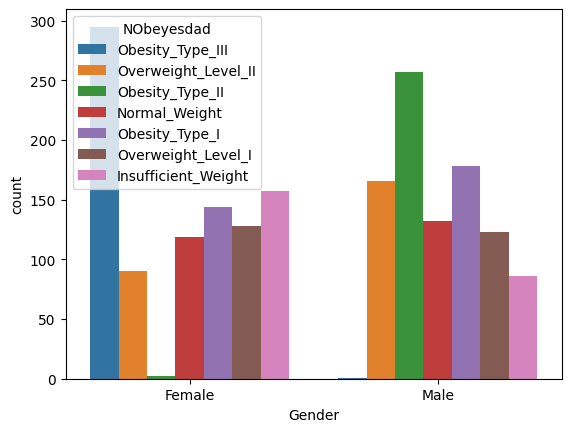

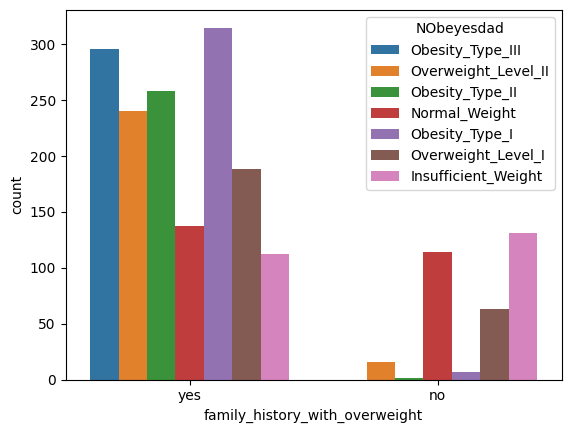

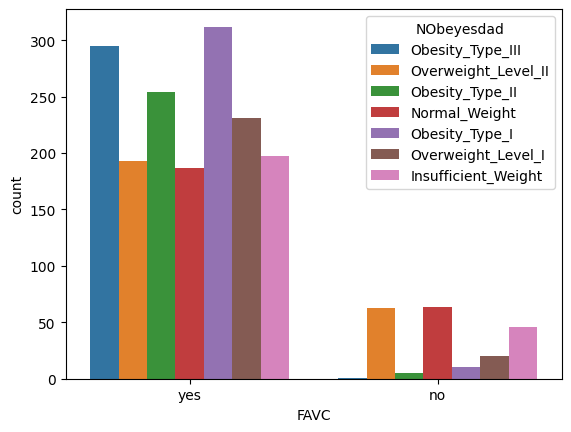

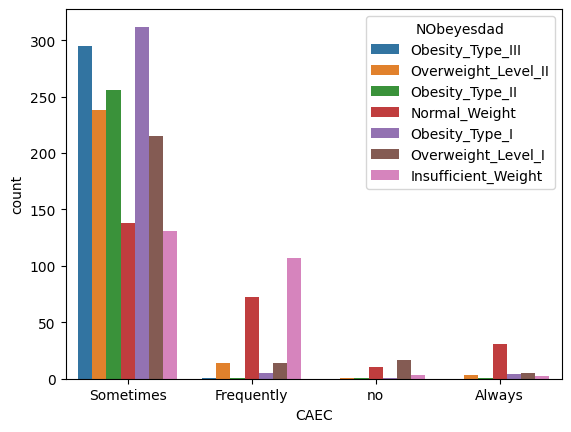

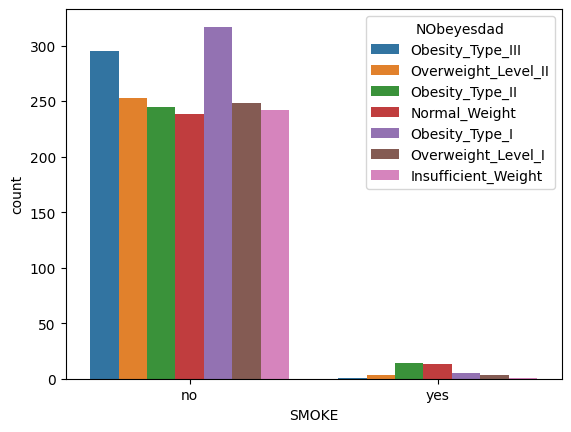

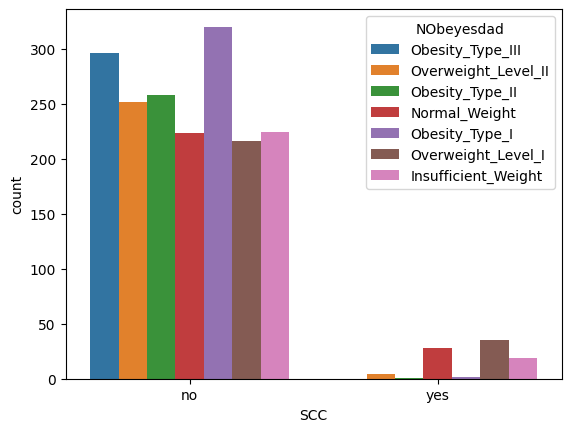

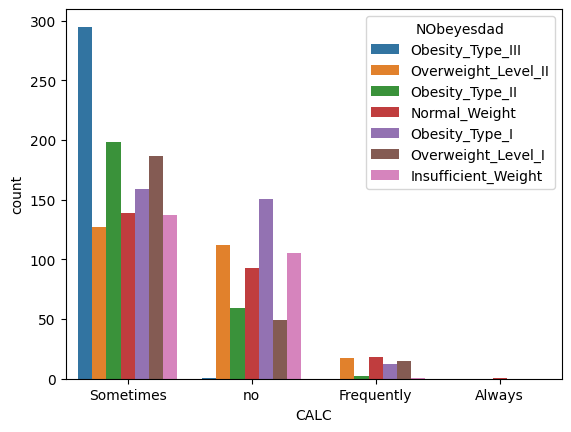

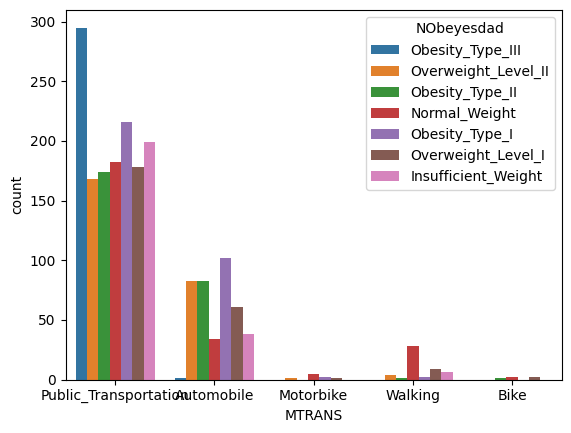

In [13]:
import seaborn as sns
for i in df:
    if df[i].nunique() <= 5:
        plt.figure()
        sns.countplot(data = df, x = i, hue ="NObeyesdad")
        plt.show()

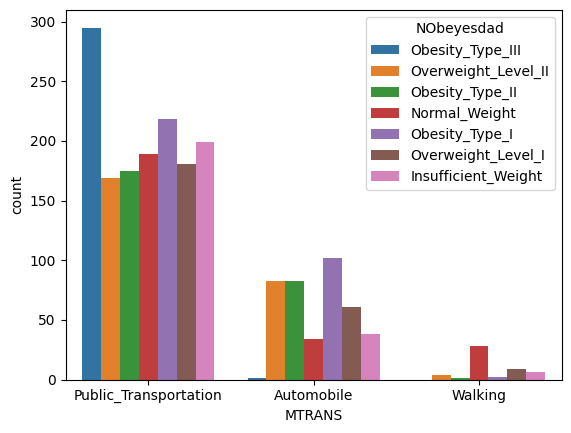

In [14]:
df['MTRANS'] = df['MTRANS'].replace({'Motorbike': 'Public_Transportation', 'Bike': 'Public_Transportation'})
df['CALC'] = df['CALC'].replace('Always', 'Frequently')
plt.figure()
sns.countplot(data = df, x = 'MTRANS', hue ="NObeyesdad")
plt.show()

In [15]:
print(df[(df['NObeyesdad'] == 'Obesity_Type_III') & (df['Gender'] == 'Male')])

    Gender  Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
905   Male   18    1.87   173.0                            yes  yes   3.0   

     NCP        CAEC SMOKE  CH2O SCC  FAF  TUE       CALC  \
905  3.0  Frequently    no   2.0  no  2.0  1.0  Sometimes   

                    MTRANS        NObeyesdad           BMI  
905  Public_Transportation  Obesity_Type_III  494723.89831  


In [16]:
print(df[(df['NObeyesdad'] == 'Obesity_Type_II') & (df['Gender'] == 'Female')])

      Gender  Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
1688  Female   25    1.63    93.0                             no   no   3.0   
1717  Female   24    1.60   100.5                            yes  yes   3.0   

      NCP       CAEC SMOKE  CH2O SCC  FAF  TUE       CALC  \
1688  4.0     Always    no   1.0  no  2.0  0.0         no   
1717  1.0  Sometimes    no   1.0  no  0.0  2.0  Sometimes   

                     MTRANS       NObeyesdad            BMI  
1688  Public_Transportation  Obesity_Type_II  350031.992171  
1717  Public_Transportation  Obesity_Type_II  392578.125000  


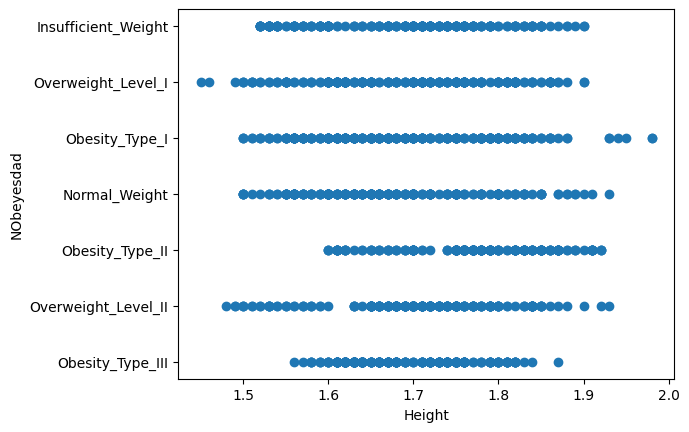

In [ ]:
plt.scatter(df['Height'], df['NObeyesdad'])
plt.xlabel('Height')
plt.ylabel('NObeyesdad')
plt.show()

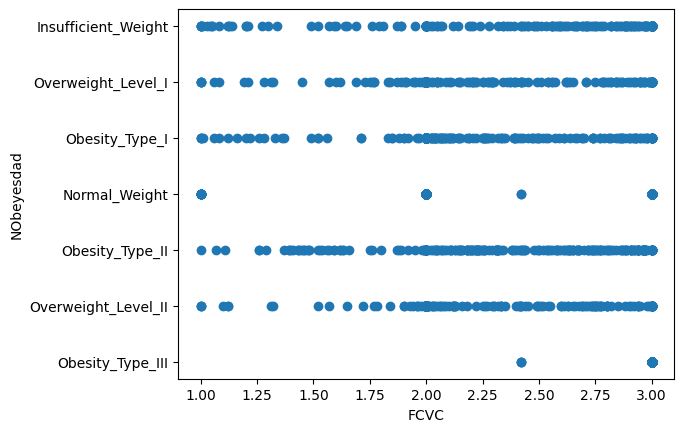

In [ ]:
plt.scatter(df['FCVC'], df['NObeyesdad'])
plt.xlabel('FCVC')
plt.ylabel('NObeyesdad')
plt.show()

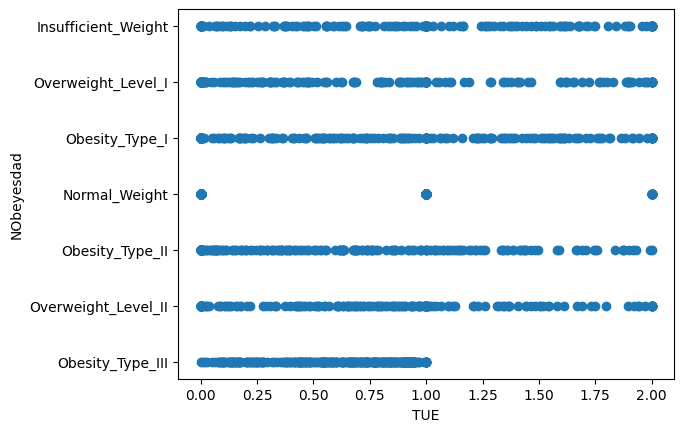

In [ ]:
plt.scatter(df['TUE'], df['NObeyesdad'])
plt.xlabel('TUE')
plt.ylabel('NObeyesdad')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
encoder = LabelEncoder()
for i in df:
    if df[i].dtype=='object':
        df[i] = encoder.fit_transform(df[i])
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,18,1.82,142.10,1,1,3.00,3.00,2,0,2.71,0,2.00,0.814,1,1,4,428994.082840
1,1,32,1.84,98.26,1,1,2.33,1.82,2,0,2.56,0,1.33,0.481,1,0,6,290229.206049
2,1,24,1.76,117.33,1,1,1.54,3.00,2,0,2.00,0,1.63,0.631,1,1,3,378777.117769
3,0,26,1.62,110.68,1,1,3.00,3.00,2,0,2.69,0,0.00,0.425,1,1,4,421734.491693
4,1,32,1.78,121.20,1,1,2.76,3.00,2,0,2.16,0,0.43,0.716,1,0,3,382527.458654


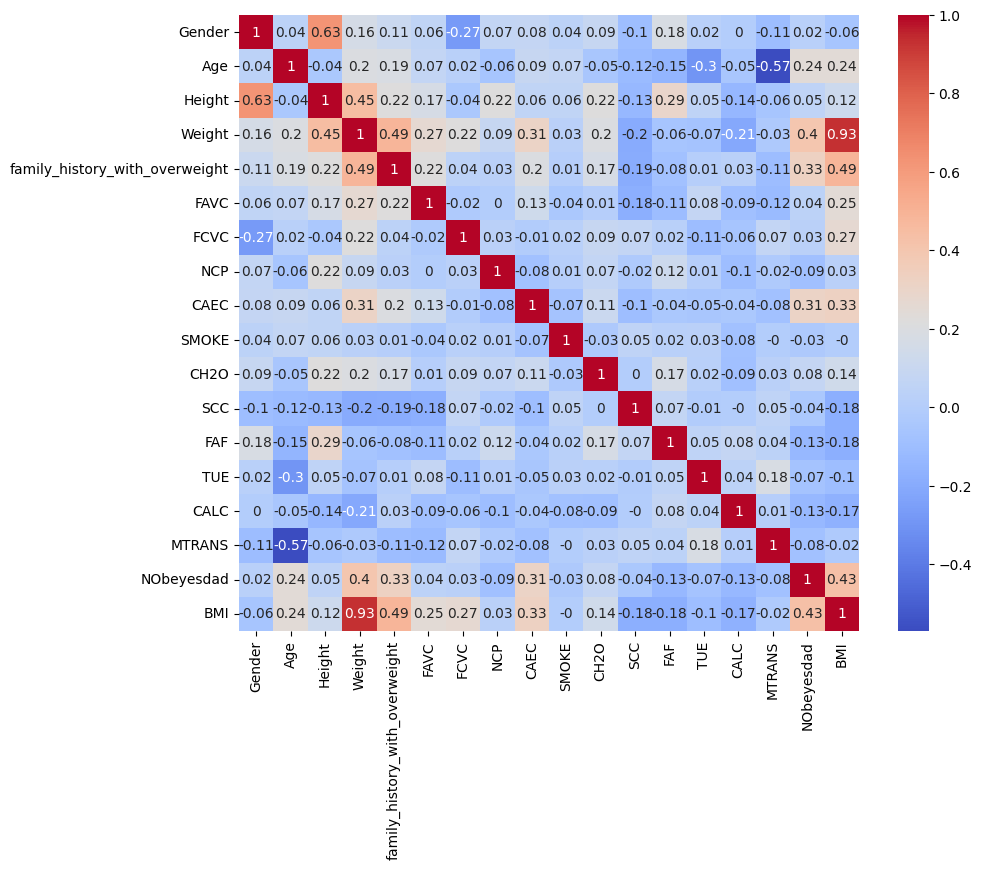

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(df.corr().round(2), annot = True, cmap = "coolwarm")
plt.show()

In [ ]:
classes = le.classes_

SVM Model

In [ ]:
SVM_Model(X_train, X_test, y_train, y_test, classes)

Starting Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


KNN Model Evaluation

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
CV Accuracy scores: [0.90425532 0.89893617 0.92021277 0.912      0.90133333]
Average CV accuracy: 0.9073

Test Accuracy: 0.9526

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       0.93      0.78      0.85        32
           2       0.94      1.00      0.97        29
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        28
           5       0.90      1.00      0.95        26
           6       0.97      0.91      0.94        34

    accuracy                           0.95       211
   macro avg       0.95      0.96      0.95       211
weighted avg       0.95      0.95      0.95       211



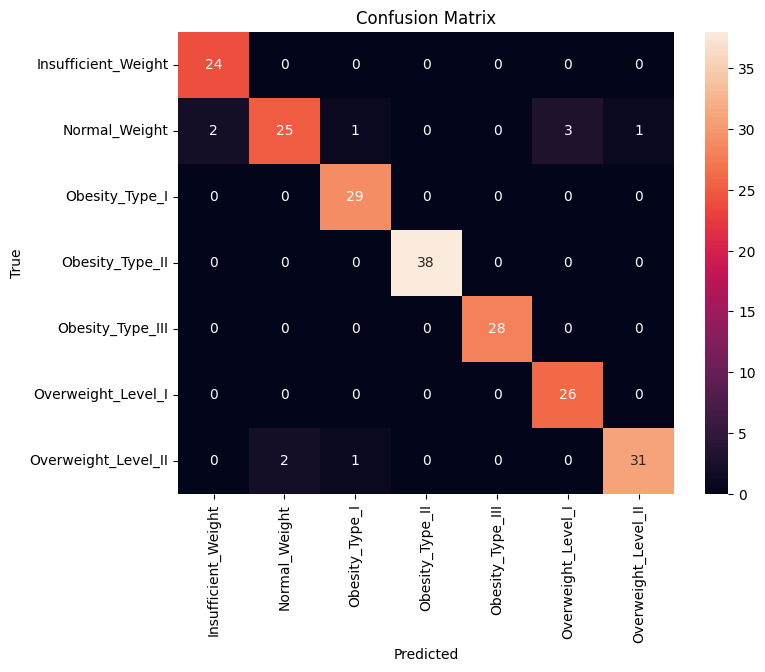

In [ ]:

predictions = KNN_Model(X_train, X_test, y_train, y_test, classes)

Logestic Regression Training (ONE VS Rest)

In [ ]:
classes = np.unique(y_train)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train)
alpha = 0.1
iterations = 100
classifiers = one_vs_rest_train(X_poly, y_train, classes, alpha, iterations)


Training classifier for class: Insufficient_Weight
Iteration    0: Cost 0.3405212736528009   
Iteration   10: Cost 0.15713366900761194   
Iteration   20: Cost 0.11983780451508771   
Iteration   30: Cost 0.10087222071793563   
Iteration   40: Cost 0.08873549512435235   
Iteration   50: Cost 0.08006877813581456   
Iteration   60: Cost 0.07346660975898302   
Iteration   70: Cost 0.06821720509637799   
Iteration   80: Cost 0.06391378954032272   
Iteration   90: Cost 0.0603036329537354   

Training classifier for class: Normal_Weight
Iteration    0: Cost 0.3595259112870529   
Iteration   10: Cost 0.2770834200245442   
Iteration   20: Cost 0.25680905832599654   
Iteration   30: Cost 0.24333825868456072   
Iteration   40: Cost 0.23311466188609112   
Iteration   50: Cost 0.2249653629233507   
Iteration   60: Cost 0.21826355218154272   
Iteration   70: Cost 0.2126185792127793   
Iteration   80: Cost 0.20777022458851516   
Iteration   90: Cost 0.20353792946538188   

Training classifier for cla

Logestic Regression Evaluation (ONE VS Rest)

In [ ]:
X_poly_test = poly.transform(X_test)
y_pred = one_vs_rest_predict(X_poly_test, y_test, classifiers)
# y_pred = one_vs_rest_predict(X_poly, y_train, classifiers)

Accuracy Score: 0.9052132701421801
Classification Report
                     precision    recall  f1-score   support

Insufficient_Weight       0.86      1.00      0.92        24
      Normal_Weight       0.93      0.78      0.85        32
     Obesity_Type_I       0.89      0.83      0.86        29
    Obesity_Type_II       0.90      1.00      0.95        38
   Obesity_Type_III       1.00      1.00      1.00        28
 Overweight_Level_I       0.85      0.88      0.87        26
Overweight_Level_II       0.91      0.85      0.88        34

           accuracy                           0.91       211
          macro avg       0.90      0.91      0.90       211
       weighted avg       0.91      0.91      0.90       211



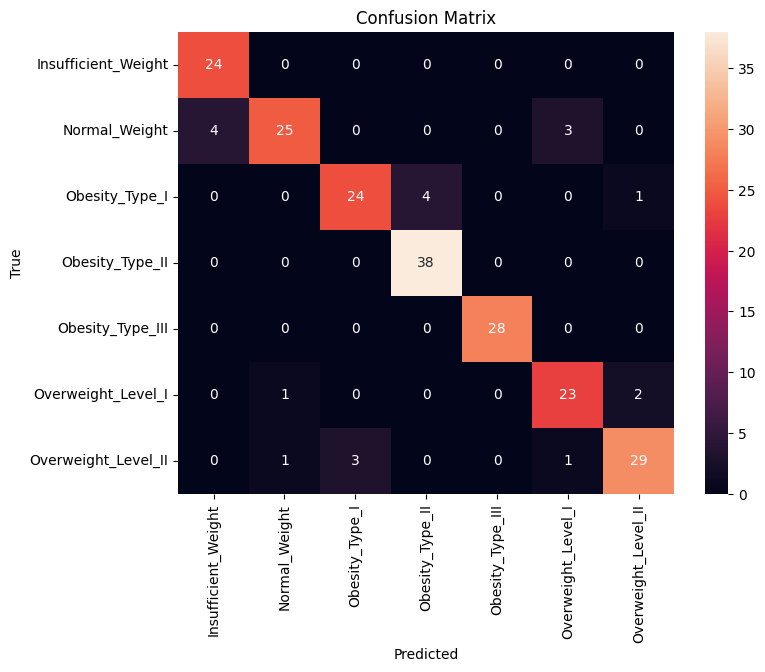

In [ ]:
confusion_Matrix(y_test, y_pred)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy: ", accuracy*100)
print(confusion_matrix(y_test, y_pred))

Validation Accuracy:  97.1563981042654
[[24  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0]
 [ 0  0 26  3  0  0  0]
 [ 0  0  0 38  0  0  0]
 [ 0  0  0  0 28  0  0]
 [ 0  0  0  0  0 25  1]
 [ 0  0  0  0  0  2 32]]


Random Forest Classifier Model

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
estimators =[]
accuracylist =[]
for i in range(5,50,5):
 estimators.append(i)

for i in estimators:
    rf = RandomForestClassifier(n_estimators=i, random_state=42)

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracylist.append(accuracy)
    print("estimator :" , i)
    print("Validation Accuracy: ", accuracy*100)


estimator : 5
Validation Accuracy:  95.260663507109
estimator : 10
Validation Accuracy:  96.2085308056872
estimator : 15
Validation Accuracy:  97.1563981042654
estimator : 20
Validation Accuracy:  98.5781990521327
estimator : 25
Validation Accuracy:  98.5781990521327
estimator : 30
Validation Accuracy:  98.5781990521327
estimator : 35
Validation Accuracy:  98.5781990521327
estimator : 40
Validation Accuracy:  98.5781990521327
estimator : 45
Validation Accuracy:  98.5781990521327


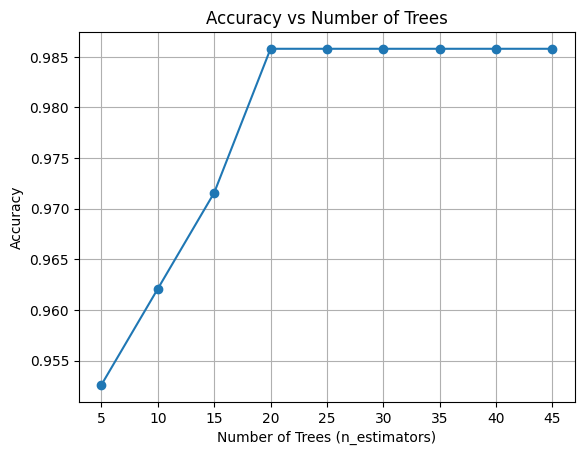

In [14]:
plt.plot(estimators, accuracylist, marker='o')
plt.title("Accuracy vs Number of Trees")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

Deployment

In [15]:
import joblib
file='diabetesClassifier'
joblib.dump(rf, 'diabetesClassifier')
model=joblib.load(open("diabetesClassifier", 'rb'))